In [1]:
# ライブラリの読み込み
using Plots
using Optim
using Random
using Distributions
using LaTeXStrings

In [2]:
struct Model{TI<:Integer, TF<:AbstractFloat}
    rstar::TF   # pH=0のときの、定常状態での名目金利の値
    bet::TF     # 割引率(オイラー方程式の定常状態より)
    sig::TF     # Real rate elasticity of output
    alp::TF     # Share of firms keeping prices fixed
    the::TF     # Price elasticity of demand
    ome::TF     # Elasticity of firms' marginal costs
    kap::TF     # Slope of the Phillips curve
    lam::TF     # Weight on output in the loss function
    rhou::TF    # AR-coefficient mark-up shocks
    rhog::TF    # AR-coefficient real rate shocks
    sigu::TF    # S.d. mark-up shock innovations
    sigg::TF    # S.d. real rate shock innovations
    Nu::TI      # Number of mark-up shock grids
    Ng::TI      # Number of real rate shock grids
    maxiter::TI # 繰り返し回数の最大値
    tol::TF     # 許容誤差
end

In [3]:
function tauchen(N,mu,rho,sigma,m)
    """
    ---------------------------------------------------
    === AR(1)過程をtauchenの手法によって離散化する関数 ===
    ---------------------------------------------------
    ※z'=(1-ρ)μ + ρ*z + ε, ε~N(0,σ_{ε}^2) を離散化する

    <input>
    ・N: 離散化するグリッドの数
    ・mu: AR(1)過程の定数項(上式のμ)
    ・rho: AR(1)過程の慣性(上式のρ)
    ・sigma: AR(1)過程のショック項の標準偏差(上式のσ_{ε})
    ・m: 離散化するグリッドの範囲に関するパラメータ
    <output>
    ・Z: 離散化されたグリッド
    ・Zprob: 各グリッドの遷移行列
    """
    Zprob = zeros(N,N) # 遷移確率の行列
    c = (1-rho)*mu # 定数項

    # 等間隔のグリッドを定める
    # 最大値と最小値
    zmax = m*sqrt(sigma^2/(1-rho^2))
    zmin = -zmax
    # グリッド間の間隔
    w = (zmax-zmin)/(N-1)

    Z  = collect(range(zmin,zmax,length=N))
    # 定常状態はmu(E[Z]=mu)
    Z .+= mu

    # グリッド所与として遷移確率を求める
    for j in 1:N # 今期のZのインデックス
        for k in 1:N  # 来期のZのインデックス
            if k == 1
                Zprob[j,k] = cdf_normal((Z[k]-c-rho*Z[j]+w/2)/sigma)
            elseif k == N
                Zprob[j,k] = 1 - cdf_normal((Z[k]-c-rho*Z[j]-w/2)/sigma)
            else
                Zprob[j,k] = cdf_normal((Z[k]-c-rho*Z[j]+w/2)/sigma) - cdf_normal((Z[k]-c-rho*Z[j]-w/2)/sigma)
            end
        end
    end

    return Z,Zprob 

end

tauchen (generic function with 1 method)

In [4]:
function cdf_normal(x)
    """
    --------------------------------
    === 標準正規分布の累積分布関数 ===
    --------------------------------
    <input>
    ・x: 
    <output>
    ・c: 標準正規分布にしたがう確率変数Xがx以下である確率
    """
    d = Normal(0,1) # 標準正規分布
    c = cdf(d,x)

    return c
    
end

cdf_normal (generic function with 1 method)

In [5]:
function ti(m)
    """
    ---------------------------------------
    === 時間反復法によってモデルを解く関数 ===
    ---------------------------------------
    <input>
    ・m: パラメータを含むコンストラクタ
    <ouutput>
    ・yvec0: 均衡での生産ギャップ
    ・pvec0: 均衡でのインフレ率
    ・rvec0: 均衡での名目金利
    ・Gg: 実質金利ショックのグリッド
    ・Gu: マークアップショックのグリッド
    """
    
    # STEP 1(a): グリッド生成
    Gg, Pg = tauchen(m.Ng,m.sig*m.rstar,m.rhog,m.sigg,3.0);
    Gu, Pu = tauchen(m.Nu,0.0,m.rhou,m.sigu,3.0);

    # 2次元グリッドの座標(g,u)を1次元のベクトルに集約する
    Ns = m.Ng*m.Nu;
    Gs = zeros(Ns,2);

    for ig in 1:m.Ng
        for iu in 1:m.Nu

            Gs[m.Nu*(ig-1)+iu,1] = Gg[ig];
            Gs[m.Nu*(ig-1)+iu,2] = Gu[iu];

        end
    end

    # 2のショックの遷移確率を下に同時分布の遷移行列を計算する
    Ps = kron(Pg,Pu);

    # STEP 1(b): 政策関数の初期値を当て推量
    # 適当な初期値
    yvec0 = zeros(Ns);
    pvec0 = zeros(Ns);
    rvec0 = zeros(Ns);
    yvec1 = zeros(Ns);
    pvec1 = zeros(Ns);
    rvec1 = zeros(Ns);

    # STEP 4: 政策関数を繰り返し計算
    diff = 1e+4; # 政策関数の繰り返し誤差
    iter = 1; # ループ・カウンター

    while diff > m.tol

        for is in 1:Ns

            # ショックの値
            g0 = Gs[is,1]
            u0 = Gs[is,2]

            # 古い政策関数から期待値(ye,pie)を計算
            ye = Ps[is,:]' * yvec0;
            pie = Ps[is,:]' * pvec0;

            # 期待値を所与として最適化
            p0 = (m.bet*pie+u0)/(1+(m.kap^2/m.lam));
            y0 = (-m.kap/m.lam)*p0
            r0 = (1/m.sig)*(ye-y0+g0) + pie;
            
            if r0 < 0
                
                y0 = ye - m.sig*(0-pie) + g0;
                p0 = m.kap*y0 + m.bet*pie + u0;
                r0 = 0.0

            end

            # 新しい政策関数を保存
            yvec1[is] = y0;
            pvec1[is] = p0;
            rvec1[is] = r0;

        end

        # 繰り返し計算誤差を確認
        ydiff = maximum(abs.(yvec1-yvec0));
        pdiff = maximum(abs.(pvec1-pvec0));
        rdiff = maximum(abs.(rvec1-rvec0));
        diff = maximum([ydiff pdiff rdiff]);

        #println([iter diff]);

        # 政策関数をアップデート
        yvec0 = copy(yvec1)
        pvec0 = copy(pvec1)
        rvec0 = copy(rvec1)

        iter += 1
    
    end

    return yvec0, pvec0, rvec0, Gg, Gu

end

ti (generic function with 1 method)

In [6]:
# カリブレーション
rstar = 3.5/4; # pH=0のときの、定常状態での名目金利の値
bet = 1/(1+rstar/100); # 割引率(オイラー方程式の定常状態より)
sig = 6.25; # Real rate elasticity of output
alp = 0.66; # Share of firms keeping prices fixed
the = 7.66; # Price elasticity of demand
ome = 0.47; # Elasticity of firms' marginal costs
kap = (1-alp)*(1-alp*bet)/alp*(1/sig+ome)/(1+ome*the); # Slope of the Phillips curve(=0.024)
lam = 0.048/16; # Weight on output in the loss function

rhou = 0.0; # AR-coefficient mark-up shocks
rhog = 0.8; # AR-coefficient real rate shocks
sigu = 0.154; # S.d. mark-up shock innovations
sigg = 1.524; # S.d. real rate shock innovations
Ng = 31; # Number of mark-up shock grids
Nu = 31; # Number of real rate shock grids

maxiter = 2000; # 繰り返し回数の最大値
tol = 1e-5; # 許容誤差

# 構造体にパラメータを格納
m = Model(rstar,bet,sig,alp,the,ome,kap,lam,rhou,rhog,sigu,sigg,Ng,Nu,maxiter,tol);

In [7]:
# 数値解を計算する
@time yvec0, pvec0, rvec0, Gg, Gu = ti(m);

# 論文中の図4-5をレプリケートする
ymat0 = zeros(m.Ng,m.Nu);
pmat0 = similar(ymat0);
rmat0 = similar(ymat0);

for ig in 1:m.Ng
    for iu in 1:m.Nu

        ymat0[ig,iu] = yvec0[m.Nu*(ig-1)+iu];
        pmat0[ig,iu] = pvec0[m.Nu*(ig-1)+iu];
        rmat0[ig,iu] = rvec0[m.Nu*(ig-1)+iu];

    end
end

# プロットを行うための準備
idu = Int(ceil(m.Nu/2)); # gについてのプロットを行う場合uはiduのインデックスで固定する
edg = Int(ceil(m.Ng/2)); # uについてのプロットを行う場合gはidgのインデックスで固定する 

  1.399368 seconds (1.87 M allocations: 1.144 GiB, 10.08% gc time, 41.97% compilation time)


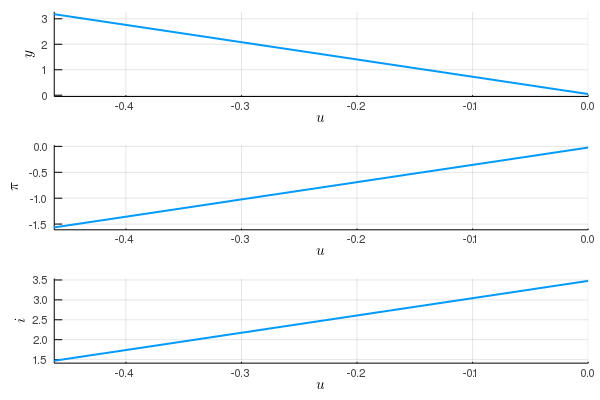

In [8]:
# Fig4
p1 = plot(Gu[1:idu],ymat0[edg,1:idu],xlabel=L"u",ylabel=L"y",legend=false)
p2 = plot(Gu[1:idu],4 .* pmat0[edg,1:idu],xlabel=L"u",ylabel=L"\pi",legend=false)
p3 = plot(Gu[1:idu],4 .* rmat0[edg,1:idu],xlabel=L"u",ylabel=L"i",legend=false)

plot(p1,p2,p3,layout=(3,1),xlim=(Gu[1],Gu[idu]),xticks=(-0.4:0.1:0.0),linewidth=2)

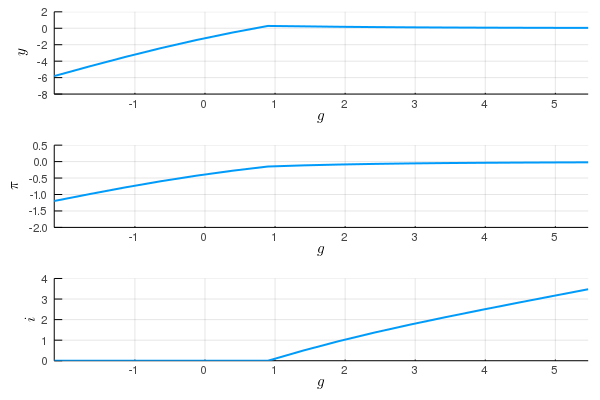

In [9]:
# Fig5
p4 = plot(Gg[1:edg],ymat0[1:edg,idu],xlabel=L"g",ylabel=L"y",ylim=(-8,2),yticks=(-8:2:2),legend=false)
p5 = plot(Gg[1:edg],4 .* pmat0[1:edg,idu],xlabel=L"g",ylabel=L"\pi",ylim=(-2,0.5),yticks=(-2:0.5:0.5),legend=false)
p6 = plot(Gg[1:edg],4 .* rmat0[1:edg,idu],xlabel=L"g",ylabel=L"i",ylim=(0,4),yticks=(0:1:4),legend=false)

plot(p4,p5,p6,layout=(3,1),xlim=(Gg[1],Gg[edg]),xticks=(-1:1:5),linewidth=2)